### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [38]:
from sklearn.datasets import fetch_openml

In [39]:
wages = fetch_openml(data_id=534, as_frame=True)
df = wages.frame

# Display the first few rows of the dataset
df.head()

/opt/conda/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [40]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
import warnings

In [42]:
# Set random seed for reproducibility
np.random.seed(42)

In [43]:
#Encode Categorical Features

In [44]:
# Identify categorical and numerical features
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.drop('WAGE')

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(drop='FIRST'), categorical_features)
    ])

# Transform target variable
df['LOG_WAGE'] = np.log(df['WAGE'])

# Split the dataset into features and target
X = df.drop(columns=['WAGE', 'LOG_WAGE'])
y = df['LOG_WAGE']
X

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married
...,...,...,...,...,...,...,...,...,...,...
529,18,no,male,5,not_member,29,White,Professional,Other,Unmarried
530,12,no,female,33,not_member,51,Other,Professional,Other,Married
531,17,no,female,25,member,48,Other,Professional,Other,Married
532,12,yes,male,13,member,31,White,Professional,Other,Married


In [45]:
#Split the Dataset into Training and Testing Sets

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
#Build Ridge Regression Models with Different Regularization

In [48]:
# Create a Ridge regression model
ridge = Ridge()

# Create a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', ridge)])

# Fit the model with different regularization strengths
alphas = [0.1, 1.0, 10.0, 100.0]
ridge_models = {}
for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge_models[alpha] = model.fit(X_train, y_train)

# Evaluate the models
ridge_scores = {}
for alpha, model in ridge_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    ridge_scores[alpha] = mse

ridge_scores
print(list(zip(X_test.columns, ridge_scores)))

[('EDUCATION', 0.1), ('SOUTH', 1.0), ('SEX', 10.0), ('EXPERIENCE', 100.0)]


In [51]:
#Interpret the Model Using Permutation Importance

In [52]:
# Choose the best model based on the lowest MSE
best_alpha = min(ridge_scores, key=ridge_scores.get)
best_model = ridge_models[best_alpha]
print (best_model)
# Calculate permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
result



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['EDUCATION', 'EXPERIENCE', 'AGE'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='FIRST'),
                                                  Index([], dtype='object'))])),
                ('regressor', Ridge(alpha=100.0))])


{'importances_mean': array([0.28939061, 0.        , 0.        , 0.28957277, 0.        ,
        0.51261138, 0.        , 0.        , 0.        , 0.        ]),
 'importances_std': array([0.0380835 , 0.        , 0.        , 0.05857234, 0.        ,
        0.12085218, 0.        , 0.        , 0.        , 0.        ]),
 'importances': array([[0.27647376, 0.26082209, 0.3144757 , 0.21762639, 0.34259804,
         0.32092463, 0.28644715, 0.28345362, 0.33910915, 0.25197554],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.33371445, 0.23879404, 0.26588164, 0.15493432, 0.34532026,
         0.25836747, 0.30447893, 0.32211252, 0.30954443, 0.36257961],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 

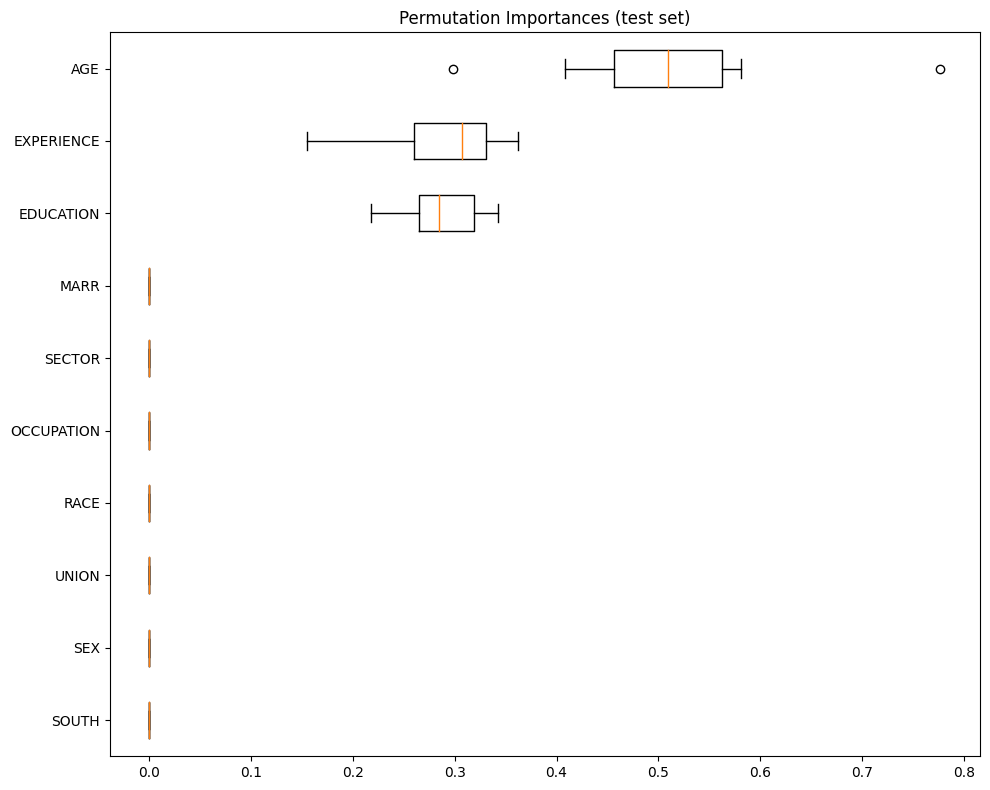

In [34]:
# Extract and plot the permutation importance
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.savefig('pitest.png')
plt.show()